# Hybrid Recommender System

Домашнее задание №4. Гибридная рекомендательная система.

В качестве обучающего датасэта можно использовать любой, но рекомендуется использовать датасэт REKKO https://boosters.pro/championship/rekko_challenge/data.
Нужно реализовать (или использовать сделанный из предыдущих домашних работ)
1. SVD-разложение
2. Архитектуру Neural matrix factorization model (NeuMF) (см. лекцию и сем по нейронным сетям + https://arxiv.org/pdf/1708.05031.pdf +  https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation), на вход которой подаются:
    - эмбединги длинны n по users 
    - эмбединги длинны n по items  
3. Гибридную архитектуру нейронную сеть, которая на вход получает:
    - эмбединги длинны n по users 
    - эмбединги длинны n по items 
    - признаки, которые можно извлечь из объекта (см.  baseline.ipynb, который есть в датасэт REKKO.)
    - признаки по пользователю (подумайте какие например можно извлечь из bookmarks.csv)

Если вы используете другой датасэт, то признаки могу быть другими.
Для гибридную архитектуру можно использовать NeuMF, рядом подать дополнительные входы. Их можно провязать полносвязанными слоями с основной частью. Можно это делать разными способами ближе к началу сети, или ближе концу. Попробуйте разные архитектуры, оцените их качество и скорость обучения. Обоснуйте свой финальный выбор.

Сравнить:
- SVD-разложения (построенного на только rating.csv) на  8, 10, 12 компонент
- Архитектуру NeuMF, где на вход подаются на SVD-разложения 8, 10, 12 компонент
- Гибридную архитектуру, где на вход подаются на SVD-разложения 8, 10, 12 компонент

Дополнительно можно поисследовать какие-то параметры архитектур. 
Для оценки качества используйте кросс-валидацию на 3 фолда.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import os
import json

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

### Load

In [2]:
DATA_PATH = '/home/ilya/repos/recsys/data/rekko'

In [3]:
train_ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'my_splits', 'train.csv'),
)
print(train_ratings.shape)
train_ratings.head()

(191421, 7)


,src_index,user_uid,element_uid,rating,ts,user_id,item_id
0,124670,163842,3488,10,4.350876e+07,0,0
1,161369,163842,8493,10,4.331289e+07,0,1
2,166450,163842,893,6,4.328506e+07,0,2
3,194406,163842,8149,6,4.314890e+07,0,3
4,194542,163842,3490,6,4.314799e+07,0,4


In [49]:
item_inner2orig = train_ratings.drop_duplicates('item_id')['element_uid'].sort_values().tolist()
json.dump(item_inner2orig, open(os.path.join(DATA_PATH, 'hw4', 'item_inner2orig.json'), 'w'))

user_inner2orig = train_ratings.drop_duplicates('user_id')['user_uid'].sort_values().tolist()
json.dump(user_inner2orig, open(os.path.join(DATA_PATH, 'hw4', 'user_inner2orig.json'), 'w'))

In [4]:
val_ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'my_splits', 'val.csv'),
)
print(val_ratings.shape)
val_ratings.head()

(9939, 7)


,src_index,user_uid,element_uid,rating,ts,user_id,item_id
0,124550,163842,5644,10,4.351188e+07,0,398
1,112022,17,1577,5,4.357656e+07,1,463
2,65491,196632,8460,10,4.383999e+07,2,70
3,50765,557081,4141,10,4.391910e+07,3,254
4,163887,25,5445,6,4.330148e+07,4,698


In [5]:
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)
print(transactions.shape)
transactions.head()

(9643012, 7)


,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50
3,6272,74296,S,4.430518e+07,2530,0,99
4,5543,340623,P,4.430518e+07,6282,0,50


In [6]:
import json

catalogue = json.load(open(os.path.join(DATA_PATH, 'catalogue.json'), 'r'))
catalogue = {int(k): v for k, v in catalogue.items()}
catalogue[1]

{'type': 'movie',
 'availability': ['purchase', 'rent'],
 'duration': 120,
 'feature_1': 6610431.116079764,
 'feature_2': 0.7732243944,
 'feature_3': 3,
 'feature_4': 1.1120138405,
 'feature_5': 0.6547073468,
 'attributes': [2786, 385, 2799, 3730, 886, 7, 11700, 42, 20, 388, 1934]}

 - `attributes` — мешок атрибутов
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`)
 - `duration` — длительность в минутах, округлённая до десятков (продолжительность серии для сериалов и многосерийных фильмов)
 - `feature_1..5` — пять анонимизированных вещественных и порядковых признаков
 - `type` — принимает значения `movie`, `multipart_movie` или `series`

In [7]:
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)
print(bookmarks.shape)
bookmarks.head()

(948216, 3)


,user_uid,element_uid,ts
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07
3,301135,2693,4.430516e+07
4,301135,2181,4.430515e+07


### Reduce Auxiliary Tables

Из таблиц `transactions`, `bookmarks`, `catalogue` уберем данные, которые не будут участвовать в трейне или валидации

In [8]:
all_users = train_ratings.user_uid.unique().tolist()
all_items = train_ratings.element_uid.unique().tolist() + val_ratings.item_id.unique().tolist()

In [9]:
def reduce(df):
    user_mask = df.user_uid.isin(all_users)
    item_mask = df.element_uid.isin(all_items)
    return df[user_mask & item_mask]

In [10]:
transactions = reduce(transactions)
bookmarks = reduce(bookmarks)
catalogue = {k: v for k, v in catalogue.items() if int(k) in all_items}

### EDA `catalogue.json`

In [11]:
catalogue[1]

{'type': 'movie',
 'availability': ['purchase', 'rent'],
 'duration': 120,
 'feature_1': 6610431.116079764,
 'feature_2': 0.7732243944,
 'feature_3': 3,
 'feature_4': 1.1120138405,
 'feature_5': 0.6547073468,
 'attributes': [2786, 385, 2799, 3730, 886, 7, 11700, 42, 20, 388, 1934]}

- `availability` -> вектор из индикаторов самых популярных атрибутов
- `duration` -> z-score
- `feature_1`, `feature_3`, `feature_4` -> минмакс шкалирование
- `feature_2` все ок
- `feature_5` -> one-hot по значениям `0., 0.44966669, 0.59271611, 0.65470735, 0.6804097`, а -1 заменю на самое популярное (0.65).
- `attributes` -> вектор индикаторов (самых популярных)

#### `attributes`

In [12]:
import itertools as it

all_attrs = list(it.chain.from_iterable([item['attributes'] for item in catalogue.values()]))
unique_attrs = sorted(list(set(all_attrs)))
len(unique_attrs)

27825

In [13]:
from tqdm.contrib.concurrent import process_map

def count_occurences(attr):
    return sum(attr in item['attributes'] for item in catalogue.values())

occurences = process_map(count_occurences, unique_attrs, max_workers=12, chunksize=10)
occurences_frac = np.array(occurences) / len(catalogue)

/tmp/ipykernel_40322/3428886715.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


100%|██████████| 27825/27825 [00:11<00:00, 2388.75it/s]


Нет фильмов без атрибутов:

In [14]:
sum(len(item['attributes']) > 0 for item in catalogue.values())

7686

Но так же нет универсальнных атрибутов, все они крайне редки:

In [15]:
np.mean(occurences_frac > .001)

0.043450134770889486

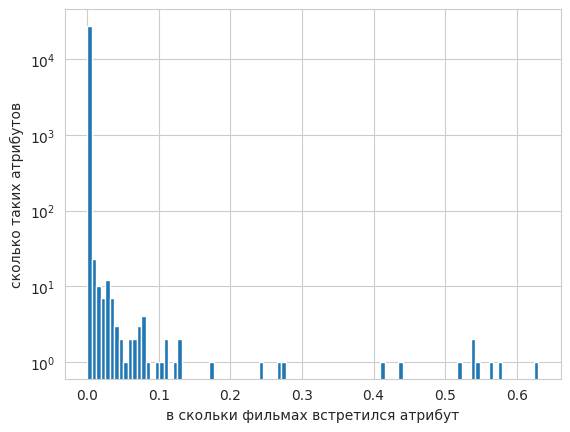

In [16]:
plt.hist(occurences_frac, bins=100)
plt.yscale('log')
plt.ylabel('сколько таких атрибутов')
plt.xlabel('в скольки фильмах встретился атрибут')
plt.show()

В качестве признаков буду использовать индикаторы атрибутов, которые встретились более чем в 5% фильмах (всего таких 31 штук).

In [17]:
np.sum(occurences_frac > .05)

33

Номера этих атрибутов:

In [18]:
selected_attrs = [attr for i, attr in enumerate(unique_attrs) if occurences_frac[i] > .05]
print(selected_attrs)

[7, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 25, 31, 32, 33, 42, 43, 51, 52, 54, 55, 83, 123, 131, 151, 170, 270, 272, 308, 388, 396, 1134, 1492]


#### `duration`

z-score тут к месту, потому что распределение колоколообразное:

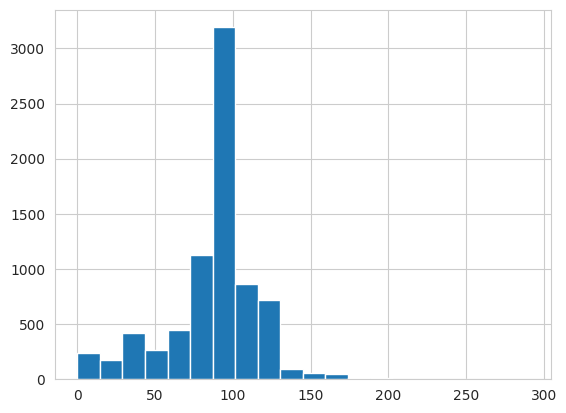

In [19]:
durations = [item['duration'] for item in catalogue.values()]
plt.hist(durations, bins=20)
plt.show()

#### `feature_1`

Минмакс шкалирование нужно, чтобы избавиться от таких больших масштабов.

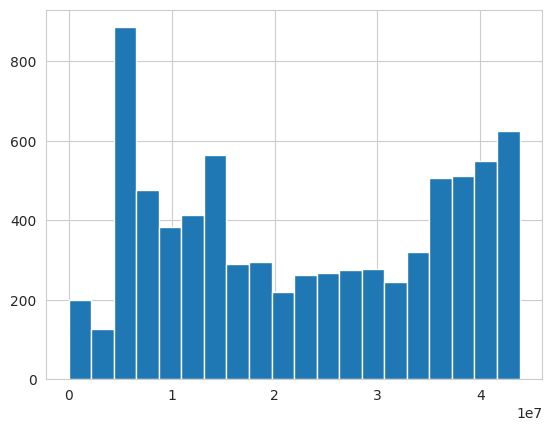

In [20]:
feature_1 = [item['feature_1'] for item in catalogue.values()]
plt.hist(feature_1, bins=20)
plt.show()

#### `feature_2`

И так все ок

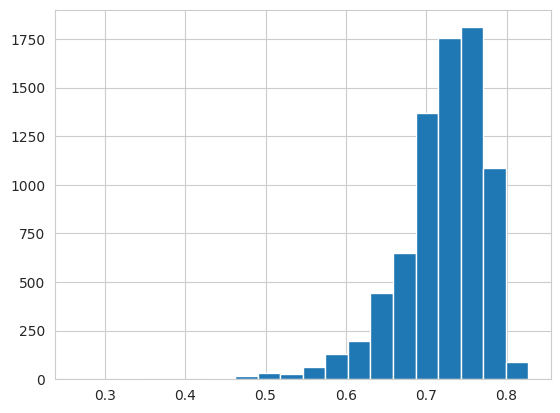

In [21]:
feature_2 = [item['feature_2'] for item in catalogue.values()]
plt.hist(feature_2, bins=20)
plt.show()

#### `feature_3`

нужен минмакс

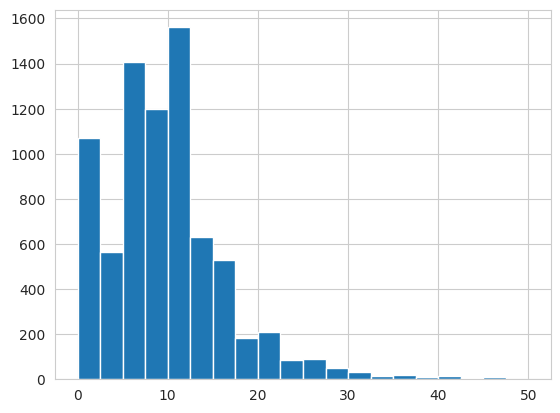

In [22]:
feature_3 = [item['feature_3'] for item in catalogue.values()]
plt.hist(feature_3, bins=20)
plt.show()

#### `feature_4`

нужен минмакс

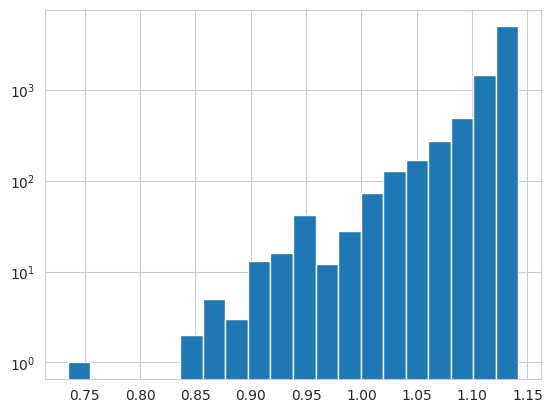

In [23]:
feature_4 = [item['feature_4'] for item in catalogue.values()]
plt.hist(feature_4, bins=20)
plt.yscale('log')
plt.show()

#### `feature_5`

Тут есть пропуски (значения -1)

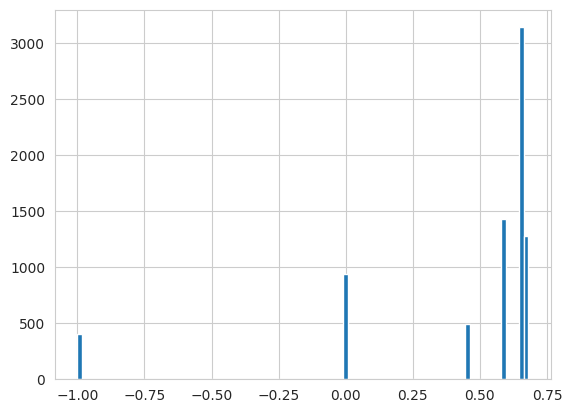

In [24]:
feature_5 = [item['feature_5'] for item in catalogue.values()]
plt.hist(feature_5, bins=100)
plt.show()

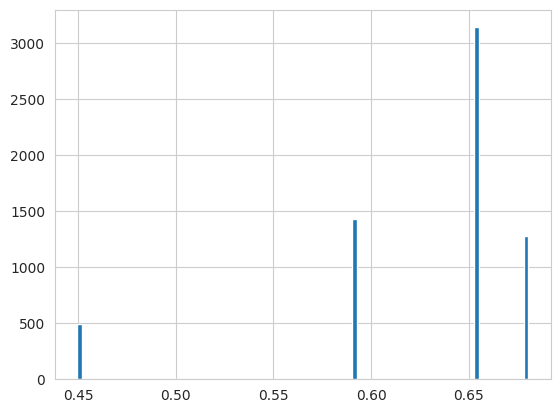

In [25]:
x = np.array(feature_5)
x = x[x > .25]
plt.hist(x, bins=100)
plt.show()

нужен one-hot, а -1 заменю на самое популярное (0.65).

In [26]:
feature_5_uniques = np.unique(feature_5).tolist()
print(feature_5_uniques)

[-1.0, 0.0, 0.4496666915, 0.5927161087, 0.6547073468, 0.6804096966]


#### `type`

In [27]:
item_type = [item['type'] for item in catalogue.values()]
set(item_type)

{'movie', 'multipart_movie', 'series'}

#### `availability`

In [28]:
availability = it.chain.from_iterable([item['availability'] for item in catalogue.values()])
set(availability)

{'purchase', 'rent', 'subscription'}

### Preprocessing & Feature Crafting `catalogue.json`

In [22]:
def zscore(array):
    return (np.array(array) - np.mean(array)) / np.std(array)

def minmax(array):
    return (np.array(array) - np.min(array)) / (np.max(array) - np.min(array))

def feature_5_processor(array):
    array = np.array(array)
    array[array == -1] = feature_5_uniques[-2]
    tmp = feature_5_uniques[1:]
    res = [[int(x == t) for t in tmp] for x in array]
    return pd.DataFrame(
        data=np.array(res),
        columns=[f'feature_5_{i}' for i in range(1, len(feature_5_uniques))]
    )

def attributes_processor():
    res = [[int(attr in item['attributes']) for attr in selected_attrs] for item in catalogue.values()]
    attributes_df = pd.DataFrame(
        data=np.array(res),
        columns=[f'attr_{attr}' for attr in selected_attrs]
    )
    return attributes_df

def type_processor():
    selected_types = ['movie', 'multipart_movie', 'series']
    res = [[int(x == t) for t in selected_types] for x in item_type]
    return pd.DataFrame(
        data=np.array(res),
        columns=[f'type_{attr}' for attr in selected_types]
    )
    
def availability_processor():
    selected_avail = ['purchase', 'rent', 'subscription']
    column = [item['availability'] for item in catalogue.values()]
    res = [[int(t in x) for t in selected_avail] for x in column]
    return pd.DataFrame(
        data=np.array(res),
        columns=[f'avail_{attr}' for attr in selected_avail]
    )

In [30]:
feature_5_processor(feature_5).head()

,feature_5_1,feature_5_2,feature_5_3,feature_5_4,feature_5_5
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0


In [31]:
attributes_processor().head()

,attr_7,attr_10,attr_11,attr_14,attr_15,attr_16,attr_17,attr_18,attr_19,attr_20,...,attr_131,attr_151,attr_170,attr_270,attr_272,attr_308,attr_388,attr_396,attr_1134,attr_1492
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
type_processor().head()

,type_movie,type_multipart_movie,type_series
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [33]:
availability_processor().head()

,avail_purchase,avail_rent,avail_subscription
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,0


In [34]:
rest = pd.DataFrame({
    'element_uid': list(catalogue.keys()),
    'duration': zscore(durations),
    'feature_1': minmax(feature_1),
    'feature_2': feature_2,
    'feature_3': minmax(feature_3),
    'feature_4': minmax(feature_4),
})
rest.head()

,element_uid,duration,feature_1,feature_2,feature_3,feature_4
0,1983,1.760988,0.037828,0.753610,0.78,0.944740
1,3783,0.747589,0.811865,0.766254,0.82,0.991841
2,5208,0.071990,0.302935,0.765425,0.54,0.975163
3,9744,1.085389,0.496496,0.757874,0.52,0.979379
4,1912,0.747589,0.210307,0.759566,0.14,0.921965


In [35]:
catalogue_df = pd.concat([
    rest,
    feature_5_processor(feature_5),
    attributes_processor(),
    type_processor(),
    availability_processor(),
], axis=1)
catalogue_df.head()

,element_uid,duration,feature_1,feature_2,feature_3,feature_4,feature_5_1,feature_5_2,feature_5_3,feature_5_4,...,attr_388,attr_396,attr_1134,attr_1492,type_movie,type_multipart_movie,type_series,avail_purchase,avail_rent,avail_subscription
0,1983,1.760988,0.037828,0.753610,0.78,0.944740,1,0,0,0,...,0,0,0,0,1,0,0,1,1,1
1,3783,0.747589,0.811865,0.766254,0.82,0.991841,0,0,0,1,...,0,0,0,0,1,0,0,1,1,1
2,5208,0.071990,0.302935,0.765425,0.54,0.975163,0,0,1,0,...,0,0,0,0,1,0,0,1,1,1
3,9744,1.085389,0.496496,0.757874,0.52,0.979379,0,0,0,1,...,0,0,0,0,1,0,0,1,1,1
4,1912,0.747589,0.210307,0.759566,0.14,0.921965,0,0,0,1,...,0,0,0,0,1,0,0,1,1,0


In [36]:
folder = os.path.join(DATA_PATH, 'hw4')
if not os.path.exists(folder):
    os.makedirs(folder)

path = os.path.join(folder, 'catalogue.csv')
catalogue_df.to_csv(path, index=False)

### EDA `transactions.csv`

In [11]:
print(transactions.shape)
transactions.head()

(679136, 7)


,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
4,5543,340623,P,4.430518e+07,6282,0,50
35,3417,412761,S,4.430517e+07,5929,0,50
65,7099,541307,S,4.430515e+07,5385,0,11
68,7347,182294,S,4.430515e+07,10687,0,50
115,4141,586236,S,4.430514e+07,5300,0,50


In [12]:
transactions.describe()

,element_uid,user_uid,ts,watched_time,device_type,device_manufacturer
count,679136.000000,679136.000000,6.791360e+05,6.791360e+05,679136.000000,679136.000000
mean,4927.093322,297591.672463,4.302545e+07,8.330301e+03,0.508216,53.419916
std,2951.383148,170223.315866,7.266019e+05,2.495086e+04,1.395887,18.165770
min,1.000000,17.000000,4.173063e+07,0.000000e+00,0.000000,0.000000
25%,2360.000000,148811.000000,4.238739e+07,2.374000e+03,0.000000,50.000000
50%,4786.000000,301133.000000,4.305859e+07,5.491000e+03,0.000000,50.000000
75%,7449.000000,445561.000000,4.364350e+07,7.163000e+03,0.000000,50.000000
max,10199.000000,593359.000000,4.430518e+07,4.079646e+06,6.000000,99.000000


In [13]:
transactions.isna().sum(axis=0)

element_uid            0
user_uid               0
consumption_mode       0
ts                     0
watched_time           0
device_type            0
device_manufacturer    0
dtype: int64

- `ts` -> минмакс
- `watched_time` -> z-score
- `device_type` -> one-hot
- `device_manufacturer` -> индикатор топ-5 популярных значений
- `consumption_mode` -> one-hot

#### `device_type`

ванхот однозначно

In [14]:
transactions.device_type.unique()

array([0, 4, 5, 1, 3, 6], dtype=uint8)

#### `device_manufacturer`

Возьму индикаторы топа пяти

In [15]:
transactions.device_manufacturer.unique()

array([50, 11, 99, 76, 90,  0, 85, 31, 67, 42, 94, 82, 59, 20, 44, 95, 52,
       97, 32, 57, 78, 43, 17, 16, 12, 87, 28,  7, 79, 55, 38, 37, 73,  4,
       24, 63, 46, 62, 41, 21, 98, 58, 18, 65, 64, 66, 40, 15, 89,  5,  2,
       51, 53, 26, 47, 23, 56, 80, 77, 86,  1], dtype=uint8)

In [16]:
sorted_tr = transactions.device_manufacturer.value_counts(normalize=True, sort=True, ascending=False)
sorted_tr

device_manufacturer
50    0.786694
90    0.065189
11    0.058038
99    0.049101
76    0.012753
        ...   
65    0.000001
53    0.000001
56    0.000001
86    0.000001
1     0.000001
Name: proportion, Length: 61, dtype: float64

In [17]:
selected_manufacturers = sorted(sorted_tr[:5].index.tolist())
selected_manufacturers

[11, 50, 76, 90, 99]

### Preprocessing & Feature Crafting for `transactions.csv`

In [30]:
cons_modes = ['P', 'S', 'R']
consumption_mode_df = pd.DataFrame(
    data=np.array([[int(t == x) for t in cons_modes] for x in transactions.consumption_mode]),
    columns=[f'cons_{x}' for x in cons_modes],
    index=transactions.index
)

print(consumption_mode_df.shape)
consumption_mode_df.head()

(679136, 3)


,cons_P,cons_S,cons_R
4,1,0,0
35,0,1,0
65,0,1,0
68,0,1,0
115,0,1,0


In [31]:
device_types = [0,1,3,5]
device_type_df = pd.DataFrame(
    data=np.array([[int(t == x) for t in device_types] for x in transactions.device_type]),
    columns=[f'device_{x}' for x in device_types],
    index=transactions.index
)
print(device_type_df.shape)
device_type_df.head()

(679136, 4)


,device_0,device_1,device_3,device_5
4,1,0,0,0
35,1,0,0,0
65,1,0,0,0
68,1,0,0,0
115,1,0,0,0


In [32]:
manufacturers_df = pd.DataFrame(
    data=np.array([[int(t == x) for t in selected_manufacturers] for x in transactions.device_manufacturer]),
    columns=[f'manuf_{x}' for x in selected_manufacturers],
    index=transactions.index
)
print(manufacturers_df.shape)
manufacturers_df.head()

(679136, 5)


,manuf_11,manuf_50,manuf_76,manuf_90,manuf_99
4,0,1,0,0,0
35,0,1,0,0,0
65,1,0,0,0,0
68,0,1,0,0,0
115,0,1,0,0,0


In [34]:
transactions_copy = transactions.copy()
transactions_copy['ts'] = minmax(transactions['ts'])
transactions_copy['watched_time'] = zscore(transactions['watched_time'])

transactions_copy = pd.concat([
    transactions_copy, consumption_mode_df, device_type_df, manufacturers_df
], axis=1)

print(transactions_copy.shape)
transactions_copy.head()

(679136, 19)


,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,cons_P,cons_S,cons_R,device_0,device_1,device_3,device_5,manuf_11,manuf_50,manuf_76,manuf_90,manuf_99
4,5543,340623,P,1.000000,-0.082093,0,50,1,0,0,1,0,0,0,0,1,0,0,0
35,3417,412761,S,0.999995,-0.096241,0,50,0,1,0,1,0,0,0,0,1,0,0,0
65,7099,541307,S,0.999990,-0.118044,0,11,0,1,0,1,0,0,0,1,0,0,0,0
68,7347,182294,S,0.999990,0.094454,0,50,0,1,0,1,0,0,0,0,1,0,0,0
115,4141,586236,S,0.999985,-0.121451,0,50,0,1,0,1,0,0,0,0,1,0,0,0


In [36]:
path = os.path.join(folder, 'transactions.csv')
transactions_copy.to_csv(path, index=False)

### EDA & Preprocessing for `bookmarks.csv`

In [49]:
n_bookmarks = bookmarks.groupby('user_uid')['element_uid'].count().sort_values(ascending=False)
n_bookmarks

user_uid
546190    422
393374    415
352028    408
112451    407
270489    372
         ... 
468607      1
365563      1
516706      1
134568      1
534414      1
Name: element_uid, Length: 6897, dtype: int64

In [50]:
n_bookmarks = n_bookmarks.to_dict()
path = os.path.join(folder, 'n_bookmarks.json')
json.dump(n_bookmarks, open(path, 'w'))

In [51]:
ts = bookmarks.groupby('user_uid')['ts']
delta_ts = ts.max() - ts.min()
delta_ts

user_uid
25        1.981984e+06
197       1.972322e+06
222       0.000000e+00
229       2.305823e+06
338       1.382518e+06
              ...     
593256    6.027991e+05
593323    0.000000e+00
593353    1.845534e+06
593357    6.139820e+05
593359    2.422618e+06
Name: ts, Length: 6897, dtype: float64

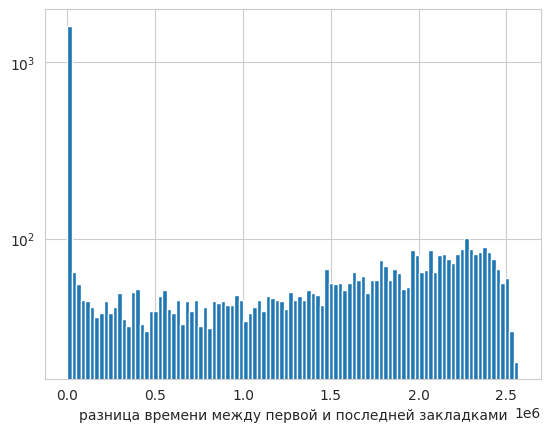

In [52]:
plt.hist(delta_ts, bins=100)
plt.yscale('log')
plt.xlabel('разница времени между первой и последней закладками')
plt.show()

In [53]:
delta_ts_values = delta_ts.values
delta_ts_values[delta_ts_values == 0] = 1
delta_ts_values = np.log(delta_ts_values)

delta_ts_scaled = pd.Series(data=delta_ts_values, index=delta_ts.index)
delta_ts_scaled

user_uid
25        14.499609
197       14.494722
222        0.000000
229       14.650948
338       14.139417
            ...    
593256    13.309339
593323     0.000000
593353    14.428279
593357    13.327721
593359    14.700359
Length: 6897, dtype: float64

In [54]:
path = os.path.join(folder, 'delta_ts.json')
json.dump(delta_ts_scaled.to_dict(), open(path, 'w'))

## Train Models

Оценивание всех моделей буду производить так же, как в прошлой домашке:

- для каждого пользователя беру самую последнюю по времени оценку, делаю предсказание для нее (релевантный объект)
- так же для каждого пользователя семплю 99 негативных айтемов, делаю предсказания для них (нерелевантные объекты)
- меряю HR@10 и NDCG@10 для получившихся выдач длины 100

Для подсчёта метрик релевантности перевожу рейтинги в метки релевантности:
- 9-10 -> 2 (highly relevant)
- 7-8 -> 1 (relevant)
- 0-6 -> 0 (irrelevant)

In [1]:
import numpy as np
import pandas as pd
import os
import json

In [2]:
DATA_PATH = '/home/ilya/repos/recsys/data/rekko'

### SVD

Для SVD использую только оценки

In [3]:
train_ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'my_splits', 'train.csv'),
).filter(items=['user_id', 'item_id', 'rating'])
print(train_ratings.shape)
train_ratings.head()

(191421, 3)


,user_id,item_id,rating
0,0,0,10
1,0,1,10
2,0,2,6
3,0,3,6
4,0,4,6


In [4]:
val_ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'my_splits', 'val.csv'),
).filter(items=['user_id', 'item_id', 'rating'])
print(val_ratings.shape)
val_ratings.head()

(9939, 3)


,user_id,item_id,rating
0,0,398,10
1,1,463,5
2,2,70,10
3,3,254,10
4,4,698,6


Добавим для каждого валидационного примера 99 негативных примеров с таким же юзером (для дальнейшей эвалюации с помощью метрик ранжирования)

In [5]:
from random import sample

positive_sets_path = os.path.join(DATA_PATH, 'my_splits', 'positive_sets.json')
positive_sets = json.load(open(positive_sets_path, 'r'))
positive_sets = {int(user_id): set(pos_items) for user_id, pos_items in positive_sets.items()}

all_items_path = os.path.join(DATA_PATH, 'my_splits', 'all_items.json')
all_items = set(json.load(open(all_items_path, 'r')))

def negative_sampling(user_id, k):
    negative_item_ids = list(all_items.difference(positive_sets[user_id]))
    return sample(negative_item_ids, k=k)

In [23]:
k = 99
val_ratings_neg = pd.concat([
    pd.DataFrame({
        'item_id': negative_sampling(uid, k),
        'user_id': [uid] * k,
        'rating': [-1] * k
    }) for uid in val_ratings.user_id
], axis=0)
val_ratings_neg.shape

(983961, 3)

In [25]:
val_ratings_with_neg = pd.concat([val_ratings, val_ratings_neg], axis=0)
val_ratings_with_neg.shape

(993900, 3)

Эксперименты и замер качества

In [ ]:
def relevance_label(rating):
    return (rating >= 8) + (rating >= 7)

In [37]:
from src import svd
from src.metrics import hit_ratio, normalized_discounted_cumulative_gain as ndcg

def svd_exp(n_factors):
    _, val_preds = svd(
        train_ratings,
        val_ratings_with_neg,
        n_factors=n_factors,
        n_epochs=10,
        batch_size=128,
        lr=3e-3,
        reg=1e-1,
        random_state=0,
        verbose=False
    )

    preds = val_preds.groupby('user_id')['pred_rating'].apply(np.array)
    targets = [[relevance_label(r)] + [0] * k for r in val_preds.rating]

    print('HR@10:', '{0:.4f}'.format(hit_ratio(preds, top_k=10)))
    print('NDCG@10:', '{0:.4f}'.format(ndcg(targets, preds, top_k=10)))

In [38]:
svd_exp(n_factors=8)

HR@10: 0.3627
NDCG@10: 0.1675


In [39]:
svd_exp(n_factors=10)

HR@10: 0.3589
NDCG@10: 0.1688


In [40]:
svd_exp(n_factors=12)

HR@10: 0.3620
NDCG@10: 0.1690


### NeuMF

Использую код с прошлой домашки. Здесь привожу только результаты эвалюации.

8 факторов:

In [52]:
! python3 train.py --eval --model ncf --name ncf-8-eval --embedding-dim 8 --batch-size 256 --gmf-weights "logs/tb/gmf-8/version_0/checkpoints/epoch=9-step=478550.ckpt" --mlp-weights "logs/tb/mlp-8-v2/version_0/checkpoints/epoch=9-step=7470.ckpt" --resume-from "logs/tb/ncf-8/version_0/checkpoints/epoch=0-step=747.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 09:55:06 14-12-2023
Restoring states from the checkpoint path at logs/tb/ncf-8/version_0/checkpoints/epoch=0-step=747.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/tb/ncf-8/version_0/checkpoints/epoch=0-step=747.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6690813899040222
       val_ndcg@10          0.4116329252719879
────────────────────────────────────────────────────────────────────────────────
Finished at 09:55:14 14-12-2023


10 факторов:

In [56]:
! python3 train.py --eval --model ncf --name ncf-10-eval --embedding-dim 10 --batch-size 256 --gmf-weights "logs/tb/gmf-10/version_0/checkpoints/epoch=9-step=478550.ckpt" --mlp-weights "logs/tb/mlp-10/version_0/checkpoints/epoch=7-step=5976.ckpt" --resume-from "logs/tb/ncf-10/version_0/checkpoints/epoch=2-step=2241.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 10:29:11 14-12-2023
Missing logger folder: ./logs/tb/ncf-10-eval
Restoring states from the checkpoint path at logs/tb/ncf-10/version_0/checkpoints/epoch=2-step=2241.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/tb/ncf-10/version_0/checkpoints/epoch=2-step=2241.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6618372201919556
       val_ndcg@10          0.4098840057849884
────────────────────────────────────────────────────────────────────────────────
Finished at 10:29:18 14-12-2023


12 факторов:

In [61]:
! python3 train.py --eval --model ncf --name ncf-12-eval --embedding-dim 12 --batch-size 256 --gmf-weights "logs/tb/gmf-12/version_0/checkpoints/epoch=9-step=478550.ckpt" --mlp-weights "logs/tb/mlp-12/version_0/checkpoints/epoch=5-step=4482.ckpt" --resume-from "logs/tb/ncf-12/version_0/checkpoints/epoch=3-step=2988.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 11:01:52 14-12-2023
Restoring states from the checkpoint path at logs/tb/ncf-12/version_0/checkpoints/epoch=3-step=2988.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/tb/ncf-12/version_0/checkpoints/epoch=3-step=2988.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.6597242951393127
       val_ndcg@10          0.40559157729148865
────────────────────────────────────────────────────────────────────────────────
Finished at 11:02:00 14-12-2023


### Hybrid Collaborating Filtering

In [26]:
! python3 train.py --eval --model hybrid --name hybrid-eval --embedding-dim 8 --batch-size 64 --gmf-weights "logs/tb/gmf-8/version_0/checkpoints/epoch=9-step=478550.ckpt" --mlp-weights "logs/tb/mlp-8-v2/version_0/checkpoints/epoch=9-step=7470.ckpt" --resume-from "logs/tb/hybrid/version_13/checkpoints/epoch=3-step=11960.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 14:06:10 14-12-2023
Missing logger folder: ./logs/tb/hybrid-eval
Restoring states from the checkpoint path at logs/tb/hybrid/version_13/checkpoints/epoch=3-step=11960.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/tb/hybrid/version_13/checkpoints/epoch=3-step=11960.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.7211993336677551
       val_ndcg@10          0.4658750891685486
────────────────────────────────────────────────────────────────────────────────
Finished at 14:06:19 14-12-2023


In [29]:
! python3 train.py --eval --model hybrid --name hybrid-10-eval --embedding-dim 10 --batch-size 64 --gmf-weights "logs/tb/gmf-10/version_0/checkpoints/epoch=9-step=478550.ckpt" --mlp-weights "logs/tb/mlp-10/version_0/checkpoints/epoch=7-step=5976.ckpt" --resume-from "logs/tb/hybrid-10/version_0/checkpoints/epoch=2-step=8970.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 14:24:33 14-12-2023
Missing logger folder: ./logs/tb/hybrid-10-eval
Restoring states from the checkpoint path at logs/tb/hybrid-10/version_0/checkpoints/epoch=2-step=8970.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/tb/hybrid-10/version_0/checkpoints/epoch=2-step=8970.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.7176778316497803
       val_ndcg@10          0.4646121859550476
────────────────────────────────────────────────────────────────────────────────
Finished at 14:24:41 14-12-2023


In [30]:
! python3 train.py --eval --model hybrid --name hybrid-12-eval --embedding-dim 12 --batch-size 64 --gmf-weights "logs/tb/gmf-12/version_0/checkpoints/epoch=9-step=478550.ckpt" --mlp-weights "logs/tb/mlp-12/version_0/checkpoints/epoch=5-step=4482.ckpt" --resume-from "logs/tb/hybrid-12/version_0/checkpoints/epoch=1-step=5980.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 14:25:09 14-12-2023
Missing logger folder: ./logs/tb/hybrid-12-eval
Restoring states from the checkpoint path at logs/tb/hybrid-12/version_0/checkpoints/epoch=1-step=5980.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/tb/hybrid-12/version_0/checkpoints/epoch=1-step=5980.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.7146593928337097
       val_ndcg@10          0.4578937590122223
────────────────────────────────────────────────────────────────────────────────
Finished at 14:25:18 14-12-2023


### Hybrid Collaborative Filtering (v2)

In [33]:
! python3 train.py --with-hidden --eval --model hybrid --name hybrid-v2-eval --embedding-dim 8 --batch-size 64 --gmf-weights "logs/tb/gmf-8/version_0/checkpoints/epoch=9-step=478550.ckpt" --mlp-weights "logs/tb/mlp-8-v2/version_0/checkpoints/epoch=9-step=7470.ckpt" --resume-from "logs/tb/hybrid-v2/version_0/checkpoints/epoch=0-step=2990.ckpt"

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Started at 14:45:14 14-12-2023
Restoring states from the checkpoint path at logs/tb/hybrid-v2/version_0/checkpoints/epoch=0-step=2990.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/tb/hybrid-v2/version_0/checkpoints/epoch=0-step=2990.ckpt
────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────
        val_hr@10           0.7233121991157532
       val_ndcg@10          0.4720586836338043
────────────────────────────────────────────────────────────────────────────────
Finished at 14:45:23 14-12-2023
